In [1]:
!pwd

/home/jupyter-skenjeye@broadinst-05974/AutoTrain


In [2]:
!pip install -e ./autotrain

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/jupyter-skenjeye%40broadinst-05974/AutoTrain/autotrain
  Attempting uninstall: autotrain
    Found existing installation: autotrain 0.0.1
    Uninstalling autotrain-0.0.1:
      Successfully uninstalled autotrain-0.0.1
  Running setup.py develop for autotrain


In [3]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.laplace import Laplace
import torch.utils.data as torchdata

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle as pkl
from pathlib import Path
from functools import partial
import pandas as pd

from tqdm.notebook import tqdm

import gym

import autotrain.gym_env
import autotrain.agent as agent_factory

# Data

In [4]:
DATA_ROOT = Path('./data')
DATA_SPLIT = 0.6

ENV_PATH = Path('./autotrain-run')
ENV_PATH.mkdir(exist_ok=True)

DEVICE = torch.device("cuda:3")

In [5]:
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def splitds(train, test, no_signal=False, pct_cap=None):
    X = np.concatenate((train.data,test.data), axis=0)
    Y = train.targets + test.targets
    
    if pct_cap:
        cap = int(pct_cap*len(X))
        X, Y = X[:cap], Y[:cap]
        
    
    if no_signal:
        print('suffling labels')
        np.random.shuffle(Y)
    
    split_id = int(len(X) * DATA_SPLIT)
    train.data, train.targets = X[:split_id], Y[:split_id]
    test.data, test.targets = X[split_id:], Y[split_id:]

def get_dataset(tfms, no_signal=False, pct_cap=None):
    train = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                        download=True, transform=tfms)

    holdout = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                           download=True, transform=tfms)
    
    splitds(train, holdout, no_signal, pct_cap)
    
    print(f'length of trainset: [{len(train)}]; len of holdout: [{len(holdout)}]')
    
    return train, holdout


In [6]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

TFMS = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), normalize])

train, holdout = get_dataset(TFMS, pct_cap=0.1)

Files already downloaded and verified
Files already downloaded and verified
length of trainset: [3600]; len of holdout: [2400]


In [7]:
def accuracy(data: torchdata.DataLoader, model: nn.Module): # phi
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data,total=len(data)):
            images, labels = batch[0].to(DEVICE), batch[1]
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

# Model

In [8]:
backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Linear(512, len(CLASSES))
backbone.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Env

In [9]:
H = 5
BS = 16
S = 2 # sampling interval
T = len(train) // BS * 3 # three epochs
K = T // S
K

337

In [10]:
env = gym.make('AutoTrain-v0')

ob = env.init(backbone=backbone,  phi=accuracy, savedir=ENV_PATH,
         trnds=train, valds=holdout, 
         T=T, H=H, S=2, lr_init=3e-4, inter_reward=0.05,
         num_workers=4, bs=BS, v=True, device=DEVICE)

[time_step:0]  initialised backbone parameters & optimizer
[time_step:0]  initialised phi value: started ...



[time_step:0]  initialised phi value: done
[time_step:0]  added observation
[time_step:0]  environment initialised : AutoTrainEnvironment with the following parameters:
                        lr_init=0.0003, inter_reward=0.05, H=5, K=337, T=675


In [11]:
def agent():
    return np.random.choice(range(env.action_space_dim))
    

In [12]:
agent()

10

In [13]:
env.step(0)

[time_step:0]  action [0] recieved
[time_step:0]  decreased lr by 10% -> [lr:0.00027]



[time_step:1]  added observation
[time_step:1]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01]]),
 0.05,
 False,
 {})

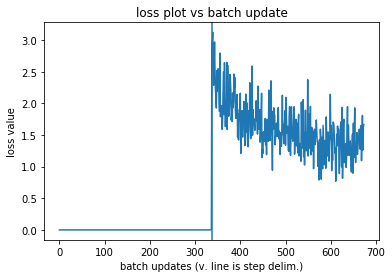

In [14]:
env.plot_loss()

In [15]:
env.step(0)

[time_step:1]  action [0] recieved
[time_step:1]  decreased lr by 10% -> [lr:0.000243]



[time_step:2]  added observation
[time_step:2]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01],
        [8.22422981e-01, 1.17928469e+00, 9.06913638e-01, ...,
         8.94882798e-01, 2.43000000e-04, 5.11612962e-01]]),
 0.05,
 False,
 {})

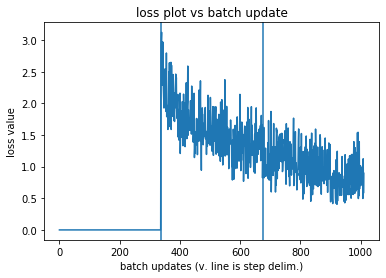

In [16]:
env.plot_loss()

In [17]:
env.logmdp

,t,phi,reward,action,weights history
0,0,0.130327,0,ENV INIT,1
1,1,0.476821,0.05,decrease lr by 10% && rewind by 0,2
2,2,0.511613,0.05,decrease lr by 10% && rewind by 0,3


In [18]:
env.step(0)

[time_step:2]  action [0] recieved
[time_step:2]  decreased lr by 10% -> [lr:0.0002187]



[time_step:3]  added observation
[time_step:3]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01],
        [8.22422981e-01, 1.17928469e+00, 9.06913638e-01, ...,
         8.94882798e-01, 2.43000000e-04, 5.11612962e-01],
        [3.95734727e-01, 4.48706627e-01, 4.71480399e-01, ...,
         1.52882740e-01, 2.18700000e-04, 5.27174272e-01]]),
 0.05,
 False,
 {})

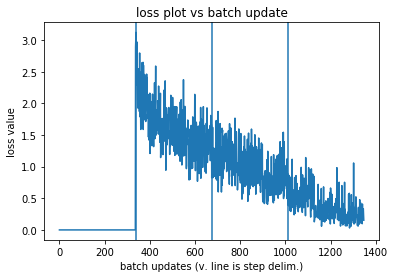

In [19]:
env.plot_loss()

In [20]:
env.step(5)

[time_step:3]  action [5] recieved



[time_step:4]  added observation
[time_step:4]  reward at the end of time step is [-0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01],
        [8.22422981e-01, 1.17928469e+00, 9.06913638e-01, ...,
         8.94882798e-01, 2.43000000e-04, 5.11612962e-01],
        [3.95734727e-01, 4.48706627e-01, 4.71480399e-01, ...,
         1.52882740e-01, 2.18700000e-04, 5.27174272e-01],
        [1.62964284e-01, 1.20547026e-01, 5.37525415e-02, ...,
         2.67867416e-01, 2.18700000e-04, 4.76838953e-01]]),
 -0.05,
 False,
 {})

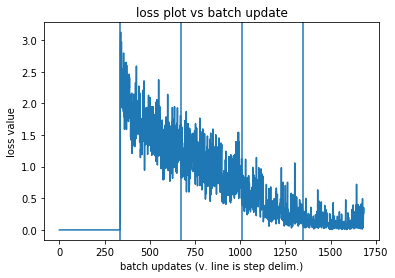

In [21]:
env.plot_loss()

In [22]:
env.step(6)

[time_step:4]  action [6] recieved
[time_step:4]  rewind weights [1] steps back
rewind



[time_step:5]  added observation
[time_step:5]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01],
        [8.22422981e-01, 1.17928469e+00, 9.06913638e-01, ...,
         8.94882798e-01, 2.43000000e-04, 5.11612962e-01],
        [3.95734727e-01, 4.48706627e-01, 4.71480399e-01, ...,
         1.52882740e-01, 2.18700000e-04, 5.27174272e-01],
        [6.19710386e-02, 1.06002629e-01, 4.34364378e-02, ...,
         5.53840399e-02, 2.18700000e-04, 4.95913068e-01]]),
 0.05,
 False,
 {})

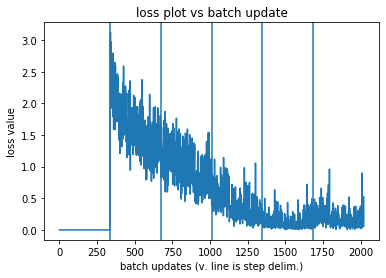

In [23]:
env.plot_loss()

In [24]:
env.step(8)

[time_step:5]  action [8] recieved
[time_step:5]  rewind weights [3] steps back
rewind
rewind
rewind



[time_step:6]  added observation
[time_step:6]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01],
        [7.45045900e-01, 1.08736038e+00, 1.35066891e+00, ...,
         1.02947330e+00, 2.18700000e-04, 5.37781237e-01]]),
 0.05,
 False,
 {})

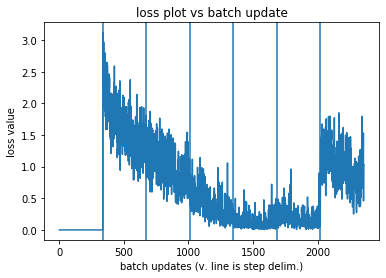

In [25]:
env.plot_loss()

In [26]:
env.logmdp

,t,phi,reward,action,weights history
0,0,0.130327,0,ENV INIT,1
1,1,0.476821,0.05,decrease lr by 10% && rewind by 0,2
2,2,0.511613,0.05,decrease lr by 10% && rewind by 0,3
3,3,0.527174,0.05,decrease lr by 10% && rewind by 0,4
4,4,0.476839,-0.05,keep current lr && rewind by 0,5
5,5,0.495913,0.05,keep current lr && rewind by 1,5
6,6,0.537781,0.05,keep current lr && rewind by 3,3


In [27]:
env.step(10)

[time_step:6]  action [10] recieved
[time_step:6]  increased lr by 10% -> [lr:0.00024057000000000004]



[time_step:7]  added observation
[time_step:7]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.00000000e-04, 1.30327408e-01],
        [2.89139819e+00, 2.98966408e+00, 3.12293577e+00, ...,
         1.66473258e+00, 2.70000000e-04, 4.76820824e-01],
        [7.45045900e-01, 1.08736038e+00, 1.35066891e+00, ...,
         1.02947330e+00, 2.18700000e-04, 5.37781237e-01],
        [7.28378296e-01, 7.16315508e-01, 7.85580158e-01, ...,
         6.76831722e-01, 2.40570000e-04, 5.52184239e-01]]),
 0.05,
 False,
 {})

In [28]:
env.step(9)

[time_step:7]  action [9] recieved
[time_step:7]  recieved RE-INIT signal or rewind_steps[4] > len(ll)
[time_step:7]  initialised backbone parameters & optimizer
[time_step:7]  initialised phi value: started ...



[time_step:7]  initialised phi value: done
[time_step:7]  added observation



[time_step:8]  added observation
[time_step:8]  reward at the end of time step is [0.05]


(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.07273507e+00, 1.66565037e+00, 1.22928333e+00, ...,
         3.33588839e-01, 2.40570000e-04, 4.61580079e-01]]),
 0.05,
 False,
 {})

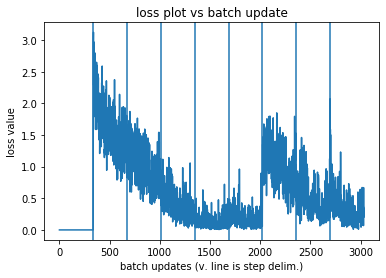

In [29]:
env.plot_loss()